In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [62]:
import numpy as np
import pandas as pd
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = 0, xmax = 0):
    plt.grid(True)
    plt.plot(x, y, "o")
    k, b = mnk_non_zero(x, y)
    xl = np.array([min(x.min(), xmin), max(xmax, x.max())])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = self.value*epsilon

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
        
    
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



In [63]:
x1 = np.array([17, 18, 19, 20, 21, 22])
y1 = np.array([0, 42, 84, 124, 166, 207]) + 700
freq1 = 4202
x2 = np.array([17, 18, 19, 20, 21, 22]) + 2
y2 = np.array([31, 69, 108, 146, 184, 223]) + 700
freq2 = 4500

x3 = np.array([17, 18, 19, 20, 21, 22, 23]) + 3
y3 = np.array([6, 41, 76, 112, 147, 182, 219]) + 700
freq3 = 4900

x4 = np.array([17, 18, 19, 20, 21, 22, 23]) + 6
y4 = np.array([14, 46, 77, 109, 140, 171, 202]) + 700
freq4 = 5555

k, b = $41.34 \pm 0.14$ $-2.4 \pm 2.6$
k, b = $38.371 \pm 0.077$ $1.8 \pm 1.7$
k, b = $35.43 \pm 0.11$ $-3.0 \pm 2.6$
k, b = $31.321 \pm 0.077$ $-5.9 \pm 2.0$


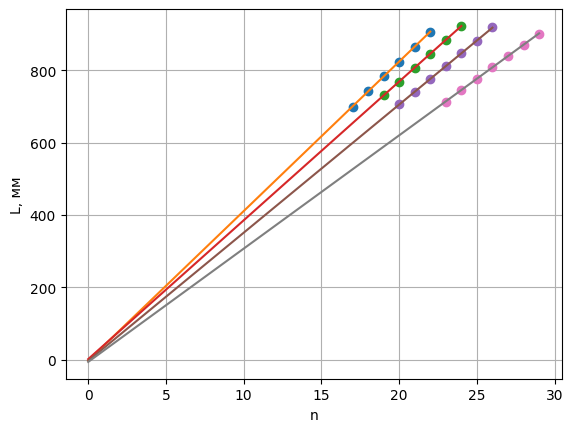

In [64]:
plt.xlabel("n")
plt.ylabel("L, мм")

k1, _ = linearcalc(x1, y1)
k2, _ = linearcalc(x2, y2)
k3, _ = linearcalc(x3, y3)
k4, _ = linearcalc(x4, y4)

plt.savefig("graph_vozduh", dpi = 300)

In [65]:
ks = pd.Series([k1, k2, k3, k4])/1000
freqs = pd.Series([freq1, freq2, freq3, freq4])
freqs = freqs.apply(lambda x : DData.tryConvert(x, 1))
cs = (2 * ks * freqs)
print(cs)

c = SerDData(cs).mean
print(c)
gamma = 0.029/8.31/(273+24)*c**2
print(gamma, gamma.epsilon)

0      $347.4 \pm 1.1$
1    $345.34 \pm 0.70$
2      $347.2 \pm 1.1$
3    $347.98 \pm 0.85$
dtype: object
$347.0 \pm 1.0$
$1.4148 \pm 0.0082$ 0.005780585387040738


In [66]:
dataf1 = pd.DataFrame()
dataf1["$\\frac{\lambda}{2}$, мм"] = ks*1000
dataf1["$\\nu$, Гц"] = freqs
dataf1["c, м/c"] = cs
dataf1

,"$\frac{\lambda}{2}$, мм","$\nu$, Гц","c, м/c"
0,$41.34 \pm 0.14$,$4202.0 \pm 1.0$,$347.4 \pm 1.1$
1,$38.371 \pm 0.077$,$4500.0 \pm 1.0$,$345.34 \pm 0.70$
2,$35.43 \pm 0.11$,$4900.0 \pm 1.0$,$347.2 \pm 1.1$
3,$31.321 \pm 0.077$,$5555.0 \pm 1.0$,$347.98 \pm 0.85$


In [67]:
dataf1.to_clipboard()

In [78]:
data1 = pd.DataFrame()
y1 = pd.Series([0, 42, 84, 124, 166, 207, "-"])
freq1 = 4202
y2 = pd.Series([31, 69, 108, 146, 184, 223, "-"])
freq2 = 4500


y3 = pd.Series([6, 41, 76, 112, 147, 182, 219])
freq3 = 4900

y4 = pd.Series([14, 46, 77, 109, 140, 171, 202]) 
freq4 = 5555

data1[f"$\Delta l$, мм при $\\nu = {freq1} Гц$"] = y1
data1[f"$\Delta l$, мм при $\\nu = {freq2} Гц$"] = y2
data1[f"$\Delta l$, мм при $\\nu = {freq3} Гц$"] = y3
data1[f"$\Delta l$, мм при $\\nu = {freq4} Гц$"] = y4

data1

data1.to_clipboard()

In [79]:
x1 = np.array([1, 2, 3, 4, 5, 7]) + 18
y1 = np.array([6, 43, 80, 117, 155, 228]) + 700
freq1 = 4500

x2 = np.array([0, 1, 2, 3, 4, 5, 6]) + 23
y2 = np.array([17, 49, 80, 112, 144, 174, 203]) + 700
freq2 = 5274

x3 = np.array([0, 1, 2, 3, 4, 5]) + 19
y3 = np.array([31, 70, 108, 146, 186, 221]) + 700
freq3 = 4200

x4 = np.array([0, 1, 2, 3, 4, 5, 6]) + 21
y4 = np.array([24, 57, 92, 128, 162, 195, 228]) + 700
freq4 = 4666

k, b = $37.057 \pm 0.090$ $1.9 \pm 2.0$
k, b = $31.14 \pm 0.22$ $1.6 \pm 5.8$
k, b = $38.17 \pm 0.28$ $6.3 \pm 6.0$
k, b = $34.21 \pm 0.21$ $5.4 \pm 5.2$


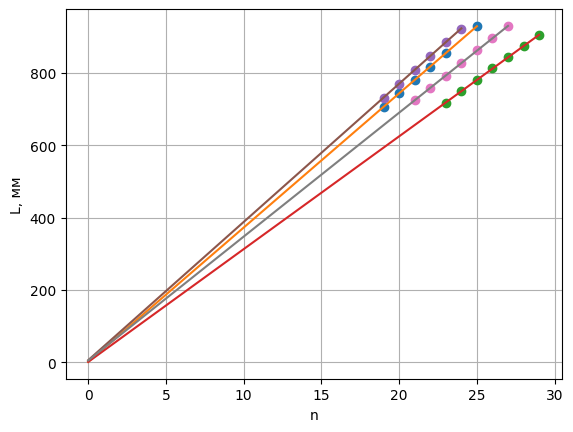

In [80]:
plt.xlabel("n")
plt.ylabel("L, мм")

k1, _ = linearcalc(x1, y1)
k2, _ = linearcalc(x2, y2)
k3, _ = linearcalc(x3, y3)
k4, _ = linearcalc(x4, y4)

plt.savefig("graph_CO2", dpi = 300)

In [82]:
ks = pd.Series([k1, k2, k3, k4])/1000
freqs = pd.Series([freq1, freq2, freq3, freq4])
cs = (2 * ks * freqs)
print(cs)
c = SerDData(cs).mean
print(c)
gamma = 0.044/8.31/(273+24)*c**2
print(gamma, gamma.epsilon)

0    $333.51 \pm 0.81$
1      $328.5 \pm 2.3$
2      $320.6 \pm 2.4$
3      $319.3 \pm 2.0$
dtype: object
$325.5 \pm 2.6$
$1.889 \pm 0.030$ 0.015940447160853403


In [72]:
dataf1 = pd.DataFrame()
dataf1["$\\frac{\lambda}{2}$, мм"] = ks*1000
dataf1["$\\nu$, Гц"] = freqs
dataf1["c, м/c"] = cs
dataf1

,"$\frac{\lambda}{2}$, мм","$\nu$, Гц","c, м/c"
0,$37.057 \pm 0.090$,4500,$333.51 \pm 0.81$
1,$31.14 \pm 0.22$,5274,$328.5 \pm 2.3$
2,$38.17 \pm 0.28$,4200,$320.6 \pm 2.4$
3,$34.21 \pm 0.21$,4666,$319.3 \pm 2.0$


In [83]:
dataf1.to_clipboard()

In [74]:
data1 = pd.DataFrame()
y1 = pd.Series([6, 43, 80, 117, 155, 228, "-"]) 
freq1 = 4500
y2 = pd.Series([17, 49, 80, 112, 144, 174, 203]) 
freq2 = 5274
y3 = pd.Series([31, 70, 108, 146, 186, 221, "-"]) 
freq3 = 4200
y4 = pd.Series([24, 57, 92, 128, 162, 195, 228]) 
freq4 = 4666

data1[f"$\Delta l$, мм при $\\nu = {freq1} Гц$"] = y1
data1[f"$\Delta l$, мм при $\\nu = {freq2} Гц$"] = y2
data1[f"$\Delta l$, мм при $\\nu = {freq3} Гц$"] = y3
data1[f"$\Delta l$, мм при $\\nu = {freq4} Гц$"] = y4
data1.to_clipboard()
data1

,"$\Delta l$, мм при $\nu = 4500 Гц$","$\Delta l$, мм при $\nu = 5274 Гц$","$\Delta l$, мм при $\nu = 4200 Гц$","$\Delta l$, мм при $\nu = 4666 Гц$"
0,6,17,31,24
1,43,49,70,57
2,80,80,108,92
3,117,112,146,128
4,155,144,186,162
5,228,174,221,195
6,-,203,-,228


In [90]:
T1 = 24 + 273.15
T2 = 30 + 273.15
T3 = 40 + 273.15
T4 = 50 + 273.15
v1 = pd.Series([367, 467, 700, 950, 1160, 1393, 1623, 1855, 2087, 2318])
v2 = pd.Series([239, 473, 708, 942, 1173, 1408, 1642, 1877, 2110, 2344])
v3 = pd.Series([243, 480, 719, 954, 1193, 1431, 1668, 1907, 2144, 2382])
v4 = pd.Series([246, 488, 730, 969, 1211, 1453, 1694, 1936, 2178, 2419])
L = DData(740, 1, E=-3)

k, b = $230.63 \pm 0.89$ $11.0 \pm 5.8$


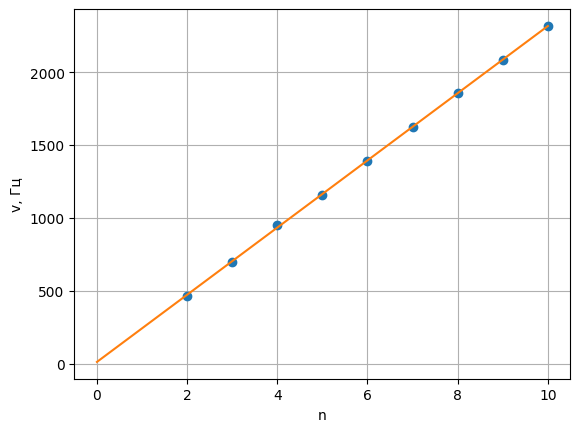

In [94]:
x_range = np.array(range(1, 11))
plt.xlabel("n")
plt.ylabel("v, Гц")

k1, _ = linearcalc(x_range[1:], v1[1:])
plt.savefig("T1", dpi = 300)

k, b = $233.842 \pm 0.098$ $5.47 \pm 0.61$


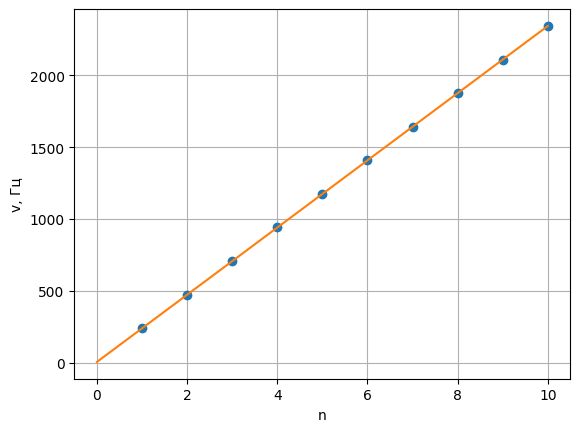

In [95]:

plt.xlabel("n")
plt.ylabel("v, Гц")

k2, _ = linearcalc(x_range, v2)
plt.savefig("T2", dpi = 300)

k, b = $237.691 \pm 0.087$ $4.80 \pm 0.54$


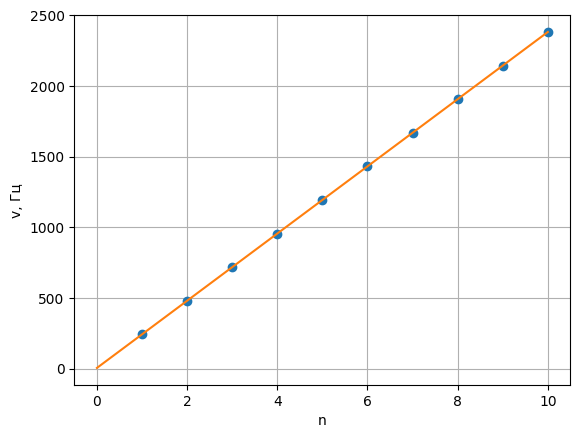

In [96]:

plt.xlabel("n")
plt.ylabel("v, Гц")

k3, _ = linearcalc(x_range, v3)
plt.savefig("T3", dpi = 300)

k, b = $241.418 \pm 0.082$ $4.60 \pm 0.51$


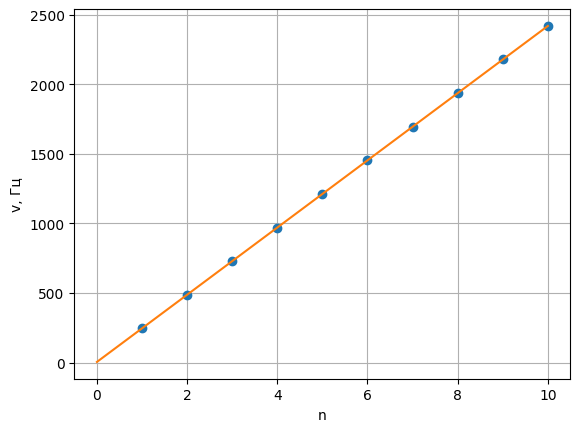

In [97]:
plt.xlabel("n")
plt.ylabel("v, Гц")
k4, _ = linearcalc(x_range, v4)
plt.savefig("T4", dpi = 300)


In [59]:
dataFT = pd.DataFrame()
dataFT["T, К"] = [T1, T2, T3, T4]
dataFT["T, К"] = dataFT["T, К"].apply(lambda x: DData(x, 0.1))
dataFT["k"] = [k1, k2, k3, k4]
dataFT["c, м/с"] = dataFT["k"]*2*L
DData.changeEInSerias(dataFT["c, м/с"], 0)
dataFT["$\gamma$"] = 0.029/8.31/dataFT["T, К"]*dataFT["c, м/с"]**2
dataFT

,"T, К",k,"c, м/с",$\gamma$
0,$297.15 \pm 0.10$,$230.63 \pm 0.89$,$341.3 \pm 1.4$,$1.368 \pm 0.011$
1,$303.15 \pm 0.10$,$233.842 \pm 0.098$,$346.09 \pm 0.49$,$1.3788 \pm 0.0039$
2,$313.15 \pm 0.10$,$237.691 \pm 0.087$,$351.78 \pm 0.49$,$1.3791 \pm 0.0039$
3,$323.15 \pm 0.10$,$241.418 \pm 0.082$,$357.30 \pm 0.50$,$1.3787 \pm 0.0039$


In [60]:
dataFT.to_clipboard()